In [2]:
# Import Lib
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from PIL import Image
from   keras.preprocessing import image, sequence
from   keras.applications import VGG16
from   keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Merge
from   keras.models import Sequential, Model
from   keras.optimizers import Nadam
from IPython.display import Image, display

Using TensorFlow backend.


In [3]:
# Read the Data labels
images_dir = os.listdir("../../../DataSet/Flicker/Flicker8k_Dataset/")

images_path   =   "../../../DataSet/Flicker/Flicker8k_Dataset/"
captions_path =   "../../../DataSet/Flicker/Flickr8k_text/Flickr8k.token.txt"
train_path    =   '../../../DataSet/Flicker/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path      =   '../../../DataSet/Flicker/Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train  = open(train_path, 'r')   .read().split("\n")
x_test   = open(val_path, 'r')     .read().split("\n")

In [4]:
# Create Tokens for each image - this is huge
tokens = {}
for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]
    
print('Total Number of Captions: ',len(captions))
print('Total Number of keys : ',len(tokens.keys()))
print('Total Number of values : ',len(tokens.values()))

Total Number of Captions:  40461
Total Number of keys :  8092
Total Number of values :  8092


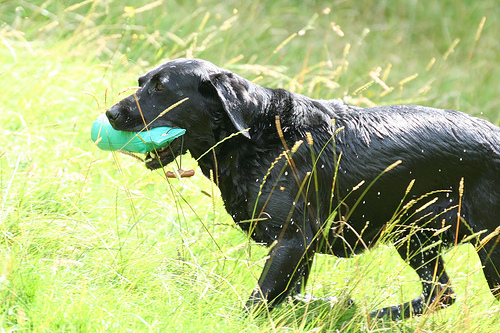

A black dog carries a green toy in his mouth as he walks through the grass .
A black dog carrying something through the grass .
A black dog has a blue toy in its mouth .
A dog in grass with a blue item in his mouth .
A wet black dog is carrying a green toy through the grass .


In [5]:
# View Sample image and caption
temp = captions[110].split("#")
z    = Image(filename=images_path+temp[0])
display(z)
for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [6]:
# View the number of training images as well as other stuffs
print("Number of Training Images {}".format(len(x_train)))
print("Number of Testing  Images {}".format(len(x_test)))
print("Number of Captions Full {}  ".format(len(tokens)))

Number of Training Images 6001
Number of Testing  Images 1001
Number of Captions Full 8092  


In [7]:
# Load the Pretrained model and load other functions as well
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

(1, 244, 244, 3)


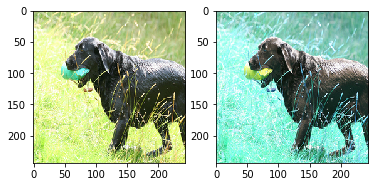

Data min max mean std:  0 255 156.48084072381977 75.33385012691765


In [25]:
# View the preprocessed image
from   PIL import Image
import PIL
def preprocessing(img_path):
    og      = Image.open(img_path)
    og      = og.resize((244,244),PIL.Image.ANTIALIAS)
    b, g, r = og.split()
    im = Image.merge("RGB", (r, g, b))
    im = np.asarray(im)[None,:,:,:]
    return og,im

ogx,x = preprocessing(images_path+temp[0]); print(x.shape)
plt.subplot(121); plt.imshow(np.squeeze(ogx)) 
plt.subplot(122); plt.imshow(np.squeeze(x)) 
plt.show()
print('Data min max mean std: ',x.min(),x.max(),x.mean(),x.std())

# =================== SAVED FOR MAYBE FUTURE USE ===================
# Old Preprocessing step
# def preprocess_input(img):
#     img = img[:, :, :, ::-1] #RGB to BGR
#     img[:, :, :, 0] -= 103.939 
#     img[:, :, :, 1] -= 116.779
#     img[:, :, :, 2] -= 123.68
#     return img

# def preprocessing(img_path):
#     im = Image.open(img_path)
#     b, g, r = im.split()
#     im = Image.merge("RGB", (r, g, b))
#     im = np.asarray(im)[None,:,:,:]
#     return im

In [26]:
# View the Summary of original VGG
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
# Remove the last layer of the VGG
vgg = Model(inputs=vgg.input,outputs=vgg.layers[-2].output)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Encoding Images using VGG #

In [29]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

In [30]:
print(temp[0])
print(get_encoding(vgg, temp[0]).shape)

1026685415_0431cbf574.jpg


AttributeError: 'tuple' object has no attribute 'ndim'

In [17]:
train_dataset = open('./Flickr8k_text/flickr_8k_train_dataset.txt','wb')
train_dataset.write("image_id\tcaptions\n")

val_dataset = open('Flickr8k_text/flickr_8k_val_dataset.txt','wb')
val_dataset.write("image_id\tcaptions\n")

In [18]:
train_encoded_images = {}

c_train = 0
for img in x_train:
    train_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write(img+"\t"+caption+"\n")
        train_dataset.flush()
        c_train += 1
train_dataset.close()

In [19]:
test_encoded_images = {}

c_test = 0
for img in x_test:
    test_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write(img+"\t"+caption+"\n")
        val_dataset.flush()
        c_test += 1
val_dataset.close()

In [20]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_encoded_images, pickle_f )  
    
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_encoded_images, pickle_f )  

# Building Vocabulary #

In [21]:
pd_dataset = pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print ds.shape

(30000L, 2L)


In [22]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print len(sentences)

30000


In [23]:
words = [i.split() for i in sentences]

In [24]:
print words[0]
print len(words)

['<start>', 'A', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in', 'the', 'snow', '.', '<end>']
30000


In [25]:
unique = []
for i in words:
    unique.extend(i)

In [26]:
print unique[:3]

['<start>', 'A', 'black']


In [27]:
print len(unique)

413377


In [28]:
unique = list(set(unique))
print len(unique)

vocab_size = len(unique)

8253


In [29]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [30]:
print word_2_indices['<start>']
print indices_2_word[4011]

4011
<start>


In [31]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print max_len

40


# Creating Padded Sequences and Next Words #

In [32]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print padded_sequences.shape
print subsequent_words.shape

(30000L,)
(30000L,)


In [33]:
print padded_sequences[0]

[[4011    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109 4880    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109 4880 4332    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109 4880 4332 4427    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [34]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print indices_2_word[padded_sequences[0][ix][iy]],
    print "\n"

print len(padded_sequences[0])

<start> raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining 

<start> A raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining 

<start> A black raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining 

<start> A black dog raining raining raining rain

In [37]:
with open('./train_encoded_images.p', 'rb') as f:
        encoded_images = pickle.load(f)

In [38]:
imgs = []

for ix in range(ds.shape[0]):
    imgs.append(encoded_images[ds[ix, 0]])

imgs = np.asarray(imgs)
print imgs.shape

(30000L, 4096L)


In [39]:
number_of_images = 1500 

In [40]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(number_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("./captions.npy", captions)
np.save("./next_words.npy", next_words)

print captions.shape
print next_words.shape

(19136L, 40L)
(19136L, 8253L)


In [41]:
images = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("./images.npy", images)

print images.shape

(19136L, 4096L)


In [42]:
image_names = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("./image_names.npy", image_names)

print len(image_names)

19136


In [16]:
! git all-go
! start .

[master 122819e8] s
 2 files changed, 4 insertions(+), 26 deletions(-)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   6e6a4b9b..122819e8  master -> master


# Reference
1. array?, H. (2018). How to convert a PIL Image into a numpy array?. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array
2. RGB), P. (2018). PIL rotate image colors (BGR -> RGB). Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/4661557/pil-rotate-image-colors-bgr-rgb
3. 